In [40]:
%cd /home/tiennv/nvtien/mae/

/mnt/Userdrive/tiennv/nvtien/mae


In [41]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import models_mae
import torchvision.transforms as transforms

In [ ]:
# define the utils

imagenet_mean = np.array([0.46458734, 0.42847479, 0.36597574])
imagenet_std = np.array([0.24277488, 0.2371218 , 0.23851591])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def attem_load_model(model, checkpoint_path):
    # weights = torch.load(checkpoint_path)['state_dict']
    weights = torch.load(checkpoint_path, map_location='cpu')
    reweights = dict()
    for k, v in weights['state_dict'].items():
        # print(k)
        # flag = 1
        # for key in ["model.net.epoch", "model.net.global_step", "model.net.pytorch-lightning_version", "model.net.state_dict", "model.net.loops"]:
        #     if key in k:
        #         flag = 0
        # if flag == 0:
        #     continue       
        # # reweights["model." + k] = v
        # if 'style' in k:
        #     continue
        reweights[k.split("model.")[1]] = v
    model.load_state_dict(reweights)
    model.eval()
    
    return model

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16', mask_ratio=-1, mask_mode='full_objmask', ptln=False):
    # build model
    if  mask_mode == 'full_objmask' and mask_ratio != -1:
        raise ValueError('mask_ratio should be -1 when mask_mode is full_objmask')
    model = getattr(models_mae, arch)(
        mask_ratio=mask_ratio,
        interpolate_ratio=1,
        mask_mode=mask_mode
    )
    # load model
    # print(checkpoint['state_dict'].keys())
    if not ptln:
        checkpoint = torch.load(chkpt_dir, map_location='cpu')
        msg = model.load_state_dict(checkpoint['model'], strict=False)
    else:
        msg = attem_load_model(model, chkpt_dir)
    # print(msg)
    msg.mask_mode = mask_mode
    msg.mask_ratio = mask_ratio
    return msg

def run_one_image(img, mask, model, mask_mode):
    x = torch.tensor(img)
    mask_tensor = transforms.PILToTensor()(mask)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_tensor, mask_mode)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [ ]:
model = prepare_model(
    # "../outputs_rand_4_bitwise_3_semi_objmask_150_checkpoint_infer/" +
    #     "outputs_rand_4_bitwise_3_semi_objmask_150/" +
    #         "files/output_ptln/sample-epoch=055-valid/loss=0.17.ckpt", 
    "/home/tiennv/nvtien/mae/outputs_rand_4_bitwise_3_semi_objmask_150_checkpoint_infer/outputs_rand_4_bitwise_3_semi_objmask_150/files/output_ptln/sample-epoch=055-valid/loss=0.17.ckpt",
    "mae_vit_base_patch16",
    # mask_ratio=0.5,
    # mask_mode='rand'
    mask_ratio=-1,
    mask_mode='full_objmask',
    ptln=True
)
# model = prepare_model(
#     "/home/tiennv/nvtien/mae/outputs/files/checkpoint-99.pth", 
#     "mae_vit_base_patch16",
#     mask_ratio=0.5,
#     mask_mode='rand'
# )

/tmp/ipykernel_2094450/1980132346.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


<All keys matched successfully>


/tmp/ipykernel_2094450/1980132346.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


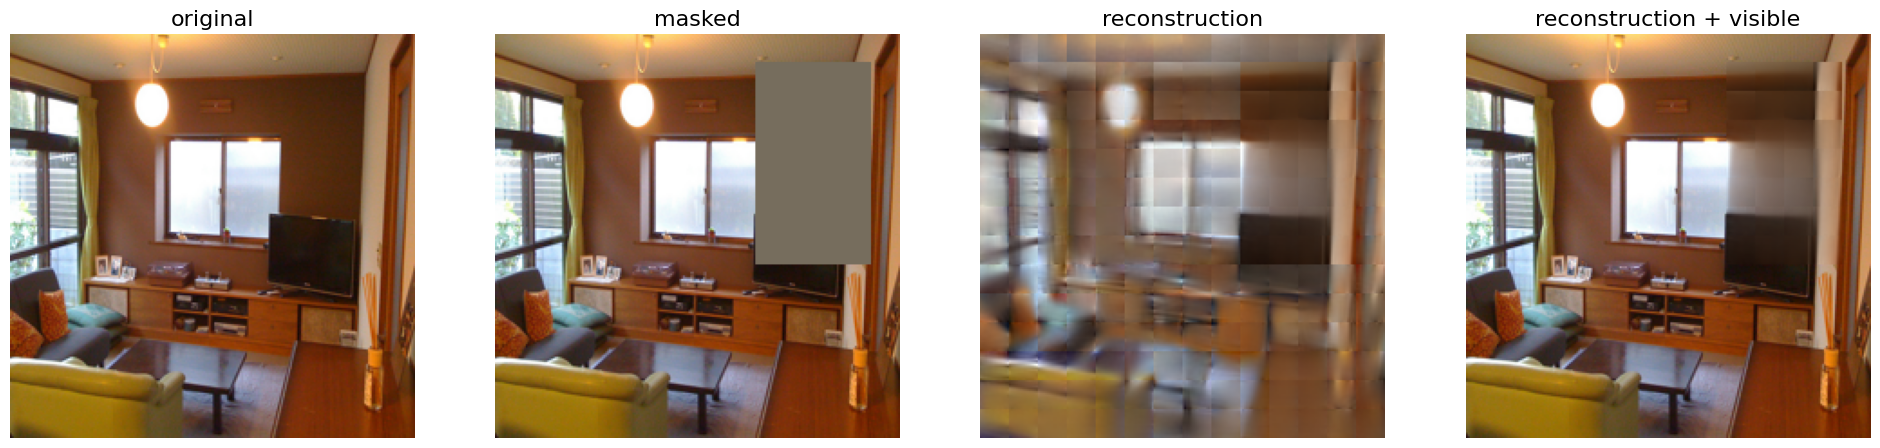

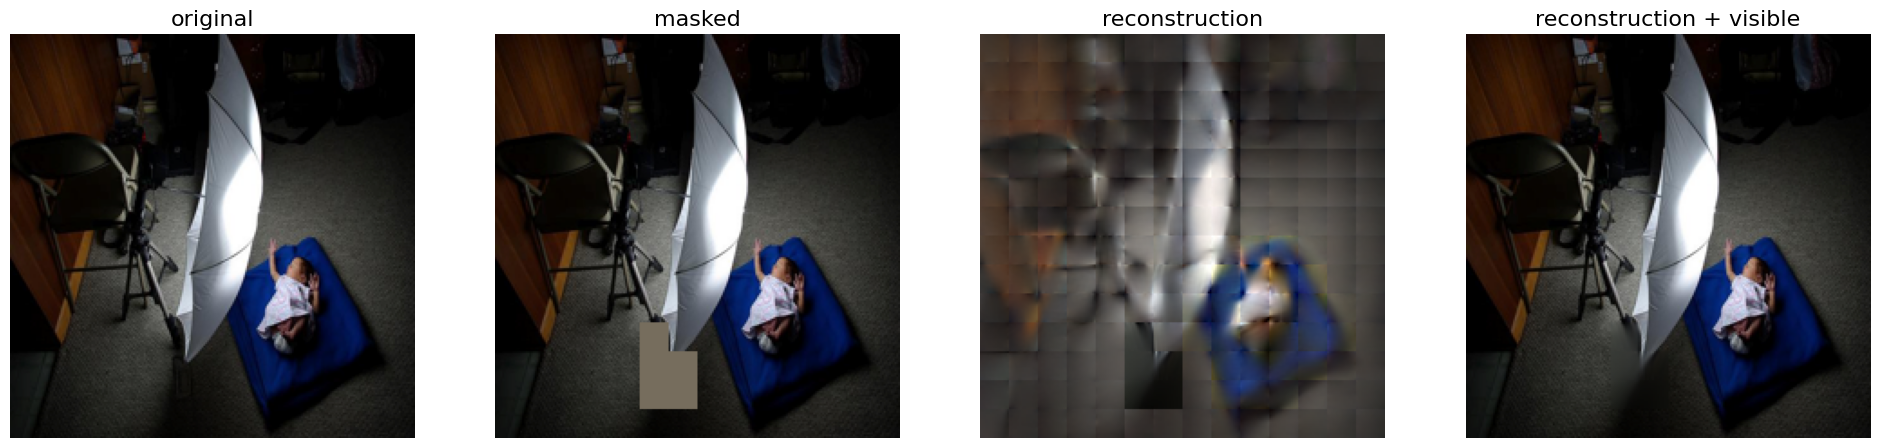

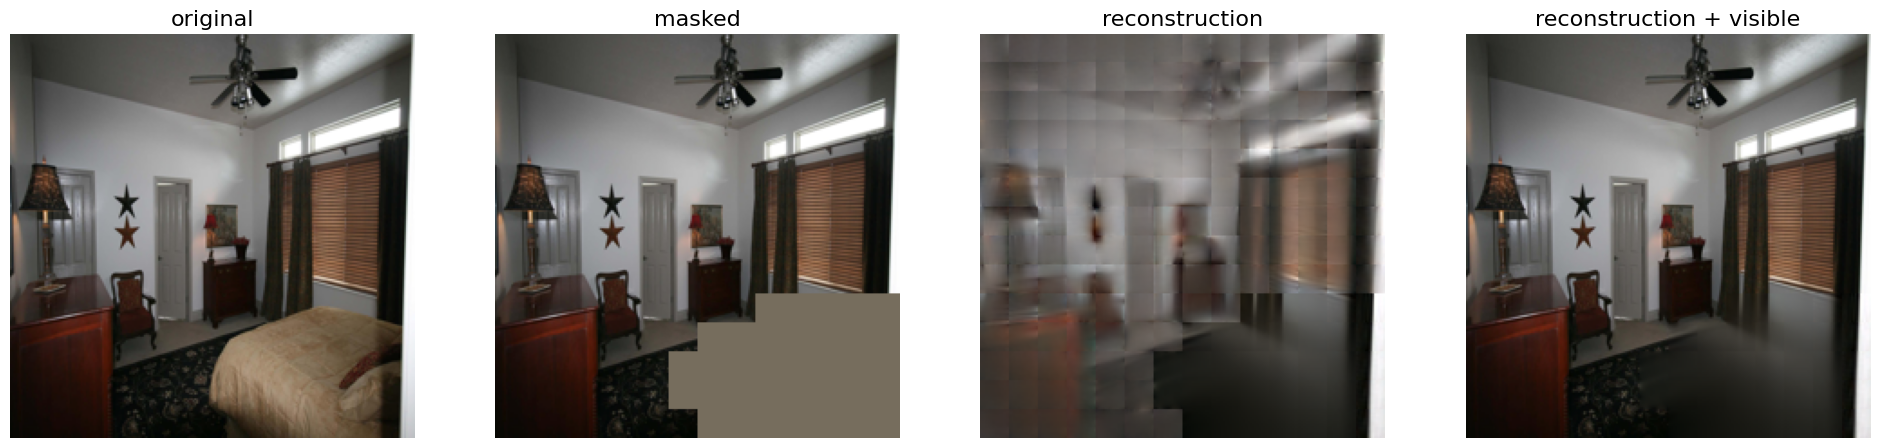

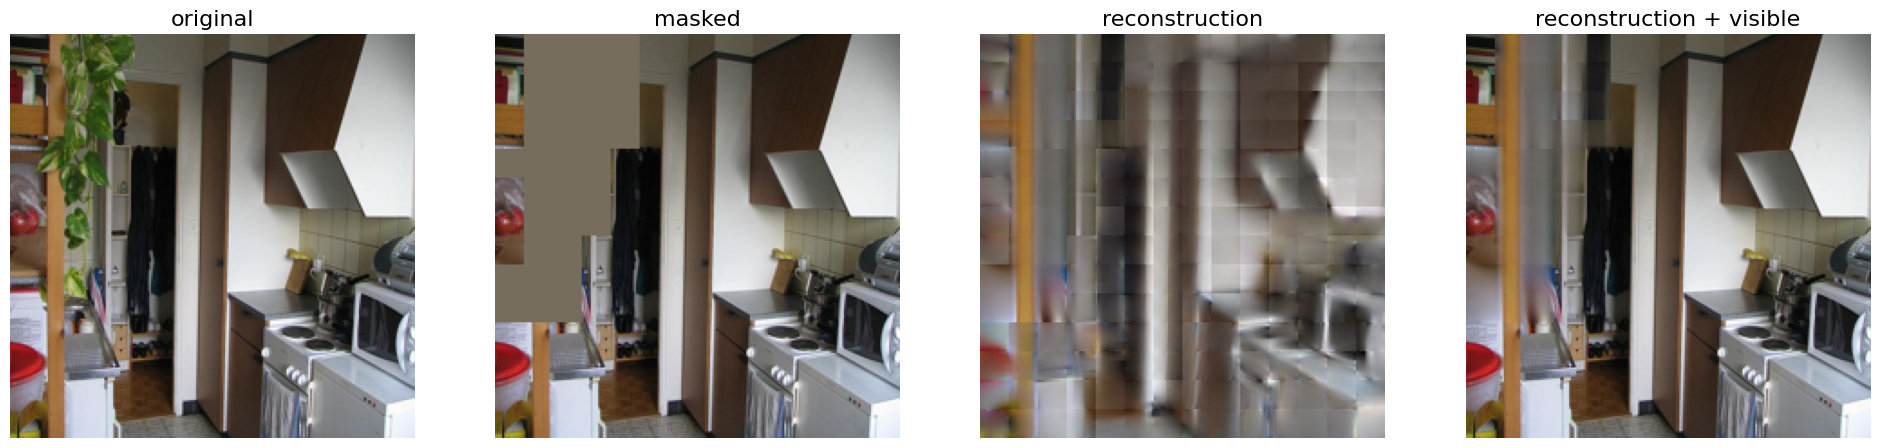

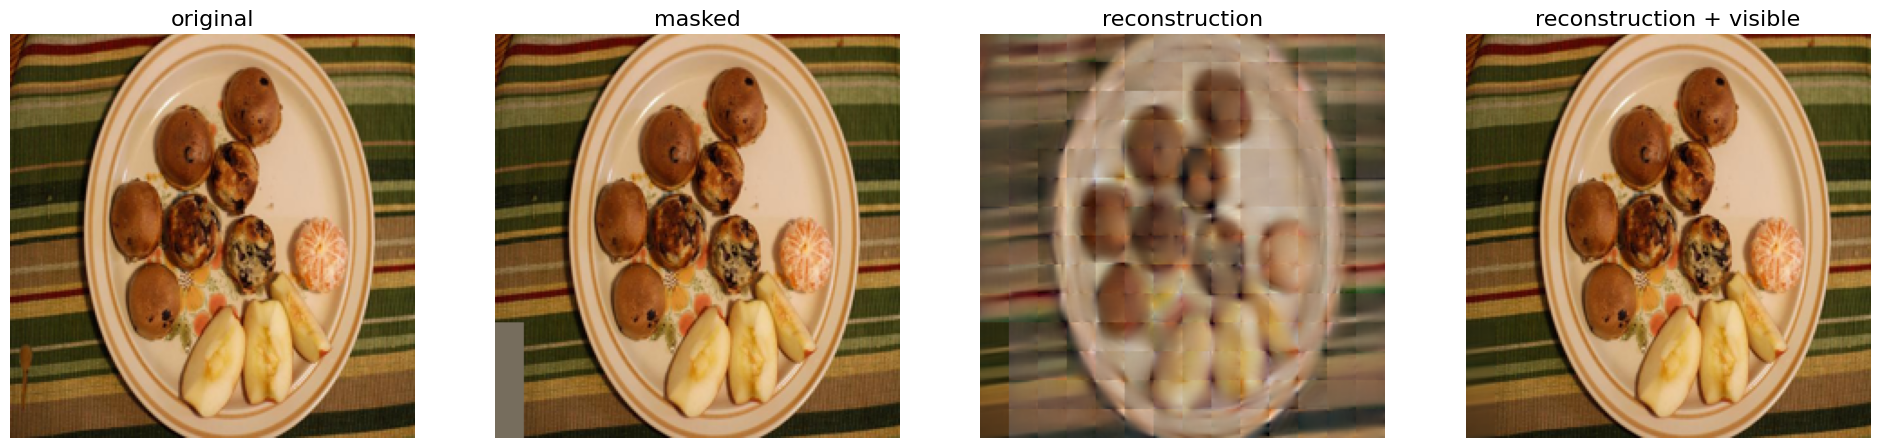

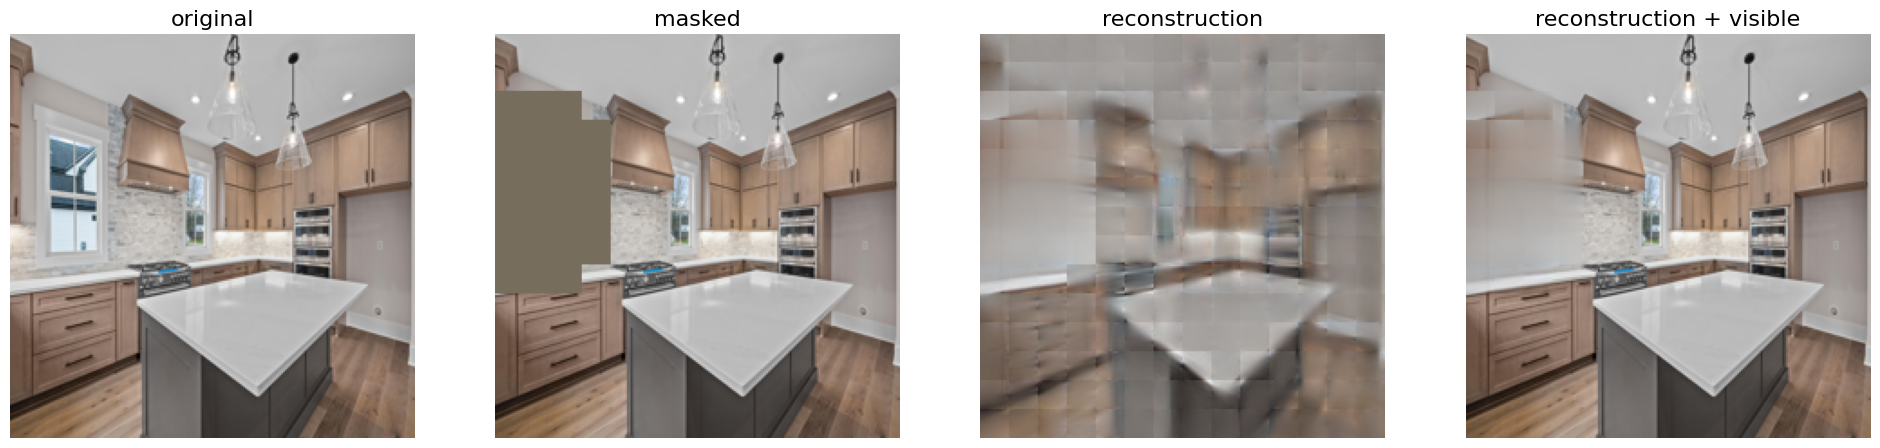

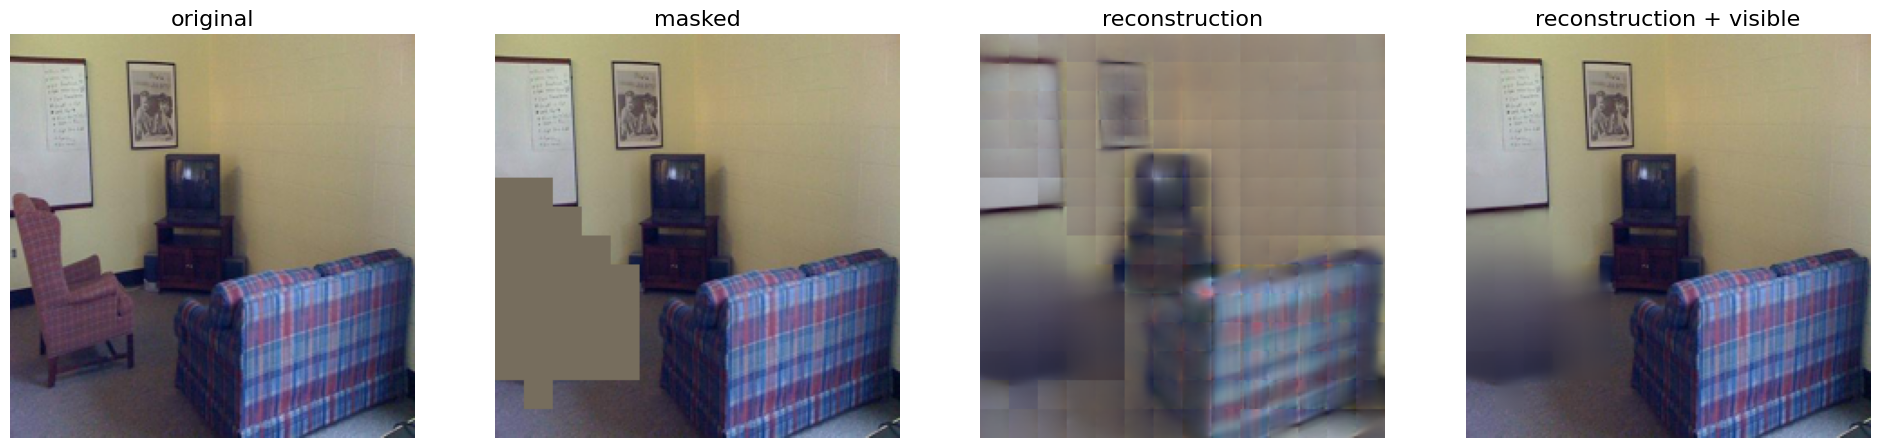

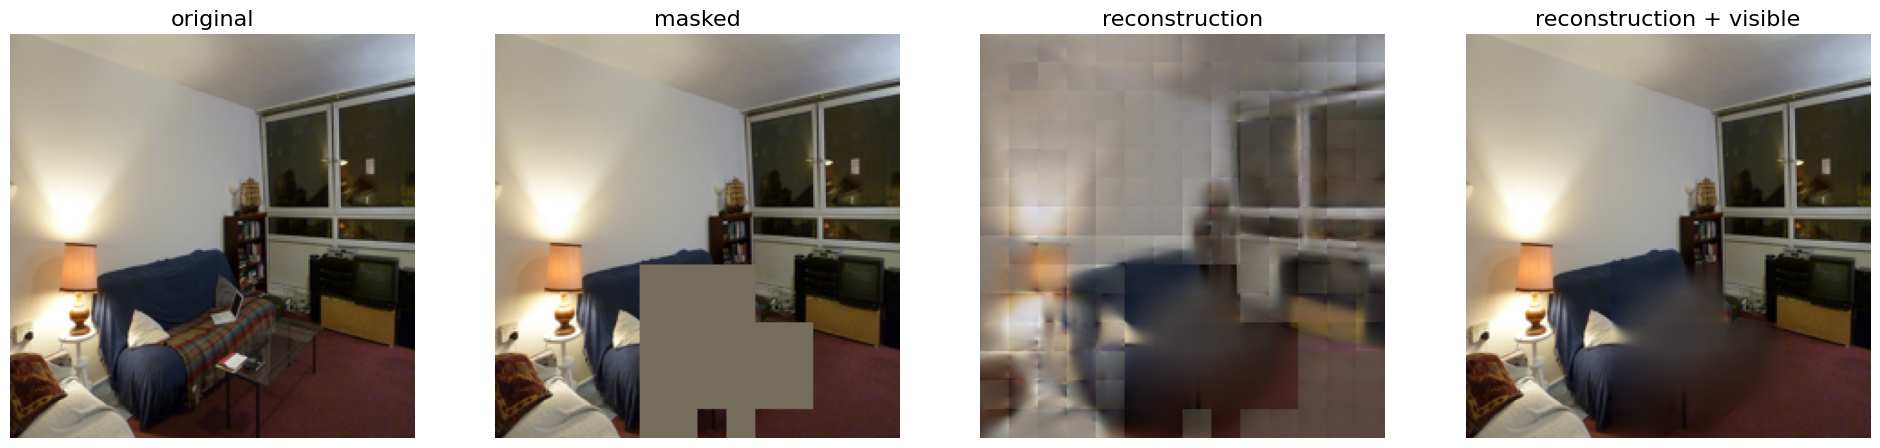

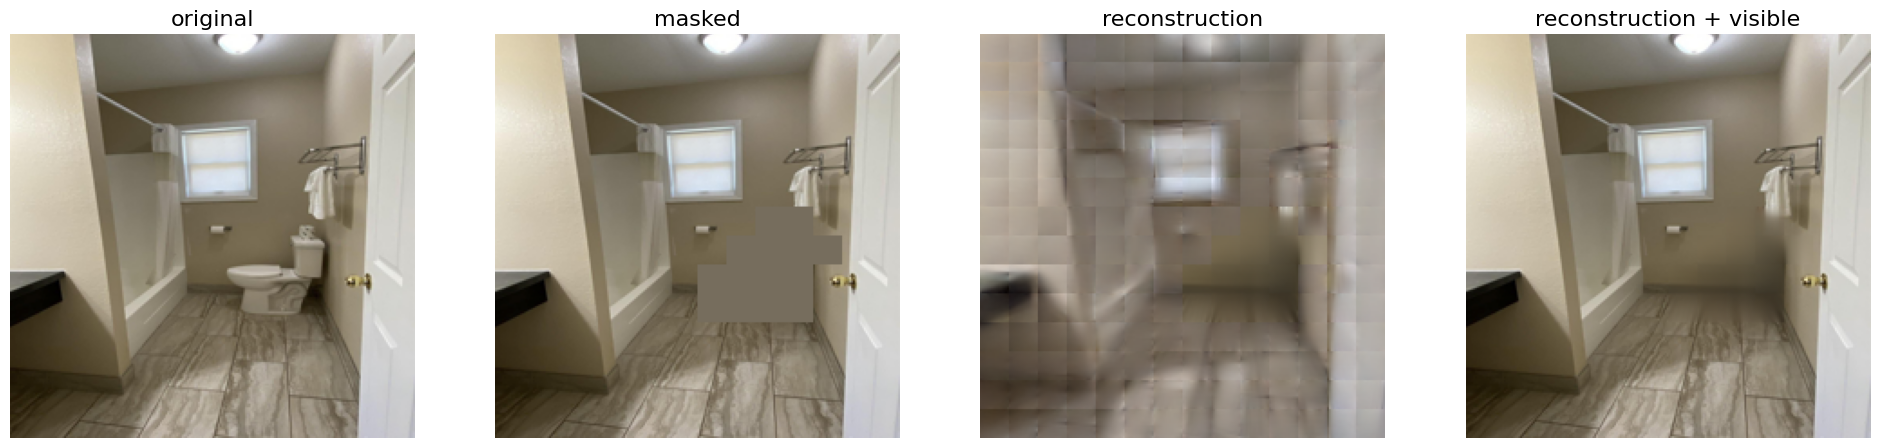

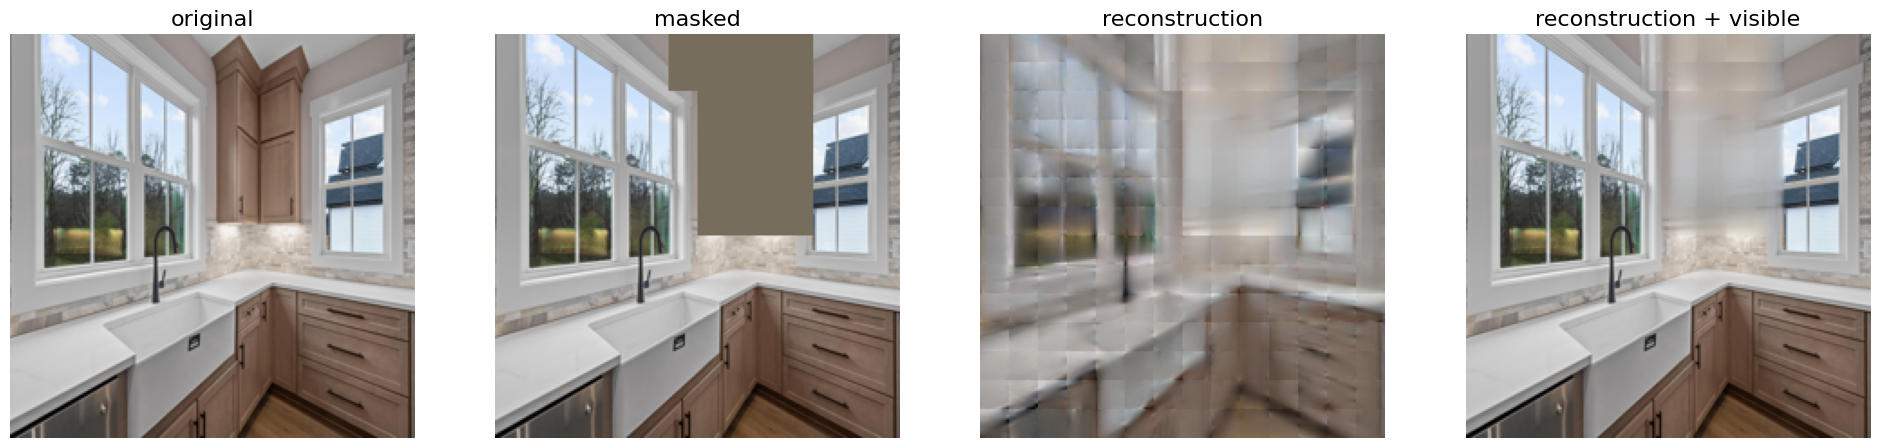

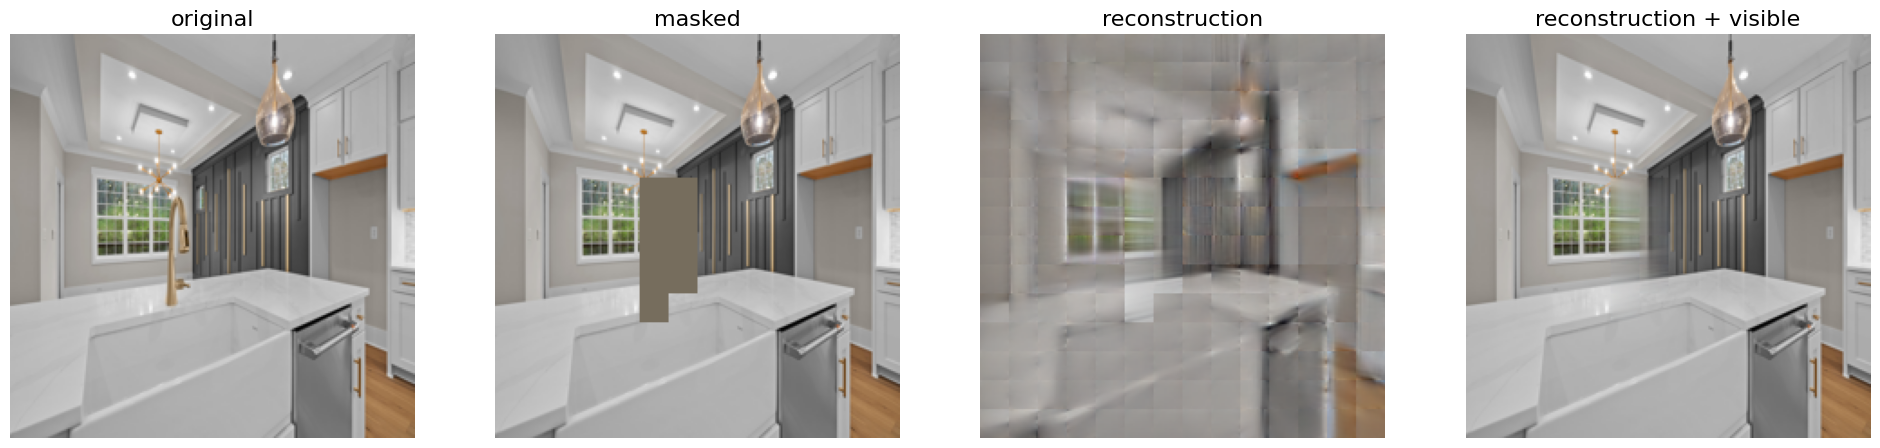

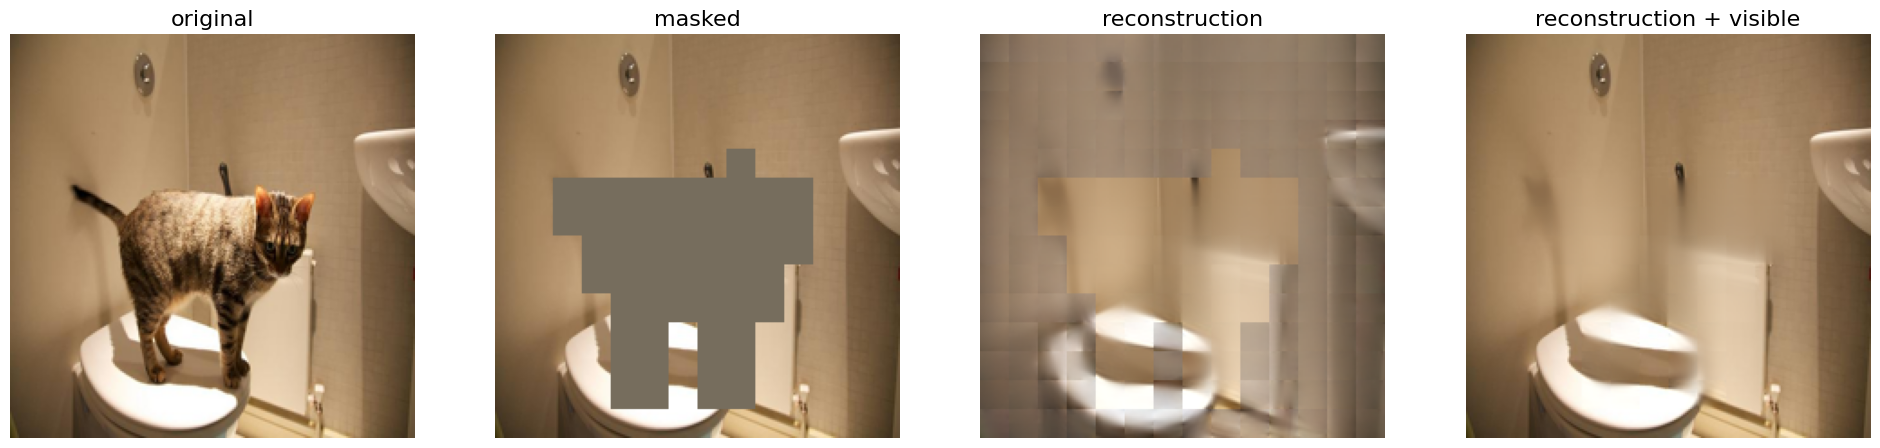

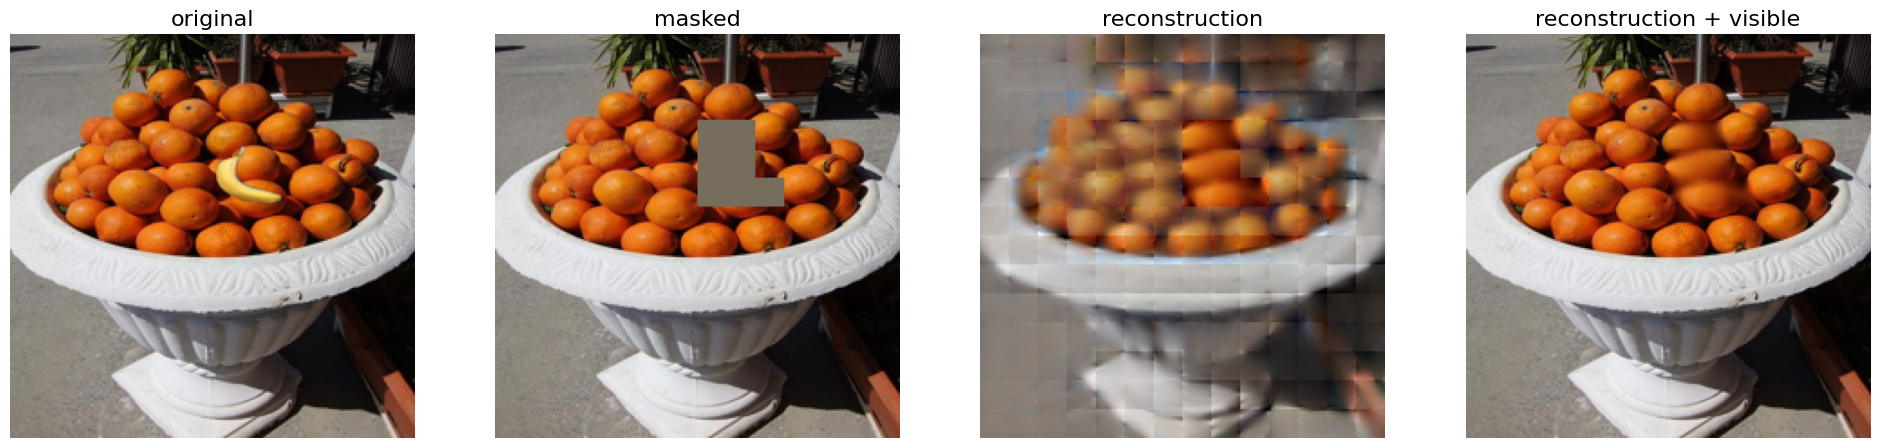

In [ ]:
for each in os.listdir("/home/tiennv/nvtien/mae/demo/example/image"):
    image_path = os.path.join("/home/tiennv/nvtien/mae/demo/example/image", each)
    mask_path = os.path.join("/home/tiennv/nvtien/mae/demo/example/mask", each)
    
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize((224, 224))
    
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img) / 255.
    
    img = img - imagenet_mean
    img = img / imagenet_std
    run_one_image(img, mask, model, mask_mode='full_objmask')

In [45]:
mask = Image.open("/home/tiennv/nvtien/mae/demo/example/mask/old.jpg").convert("L")
mask = mask.resize((224, 224))

/tmp/ipykernel_2094450/1980132346.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


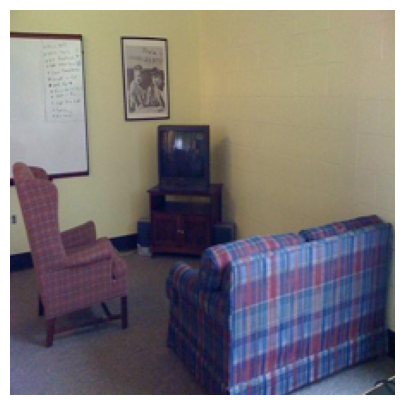

In [46]:
img = Image.open("/home/tiennv/nvtien/mae/demo/example/image/old.jpg").convert("RGB")
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

/tmp/ipykernel_2094450/1980132346.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


MAE with pixel reconstruction:


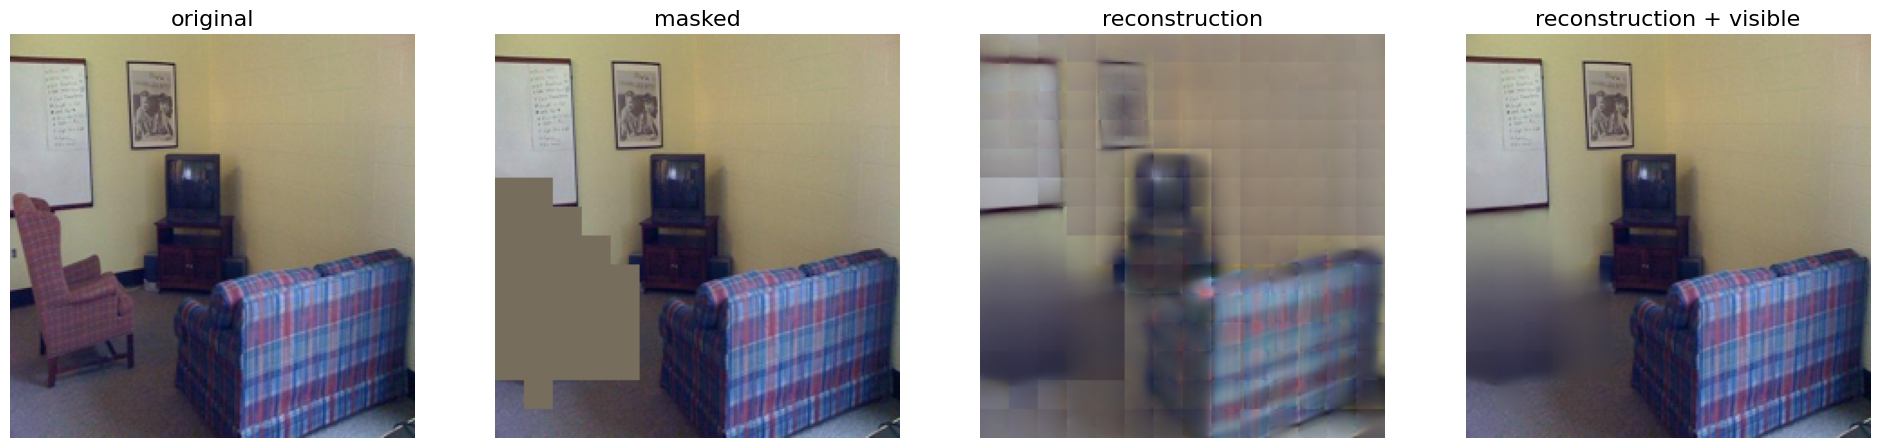

In [47]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, mask, model)